# DBSCAN Project

Source: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers

Margarida G. M. S. Cardoso, margarida.cardoso '@' iscte.pt, ISCTE-IUL, Lisbon, Portugal

Data Set Information:

Provide all relevant information about your data set.

Attribute Information:

1) FRESH: annual spending (m.u.) on fresh products (Continuous);
2) MILK: annual spending (m.u.) on milk products (Continuous);
3) GROCERY: annual spending (m.u.)on grocery products (Continuous);
4) FROZEN: annual spending (m.u.)on frozen products (Continuous)
5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
6) DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);
7) CHANNEL: customers  Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)
8) REGION: customers  Region Lisnon, Oporto or Other (Nominal)

In [59]:
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.naive_bayes import logsumexp
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler
from kmodes.kmodes import KModes
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
from sklearn.cluster import KMeans



wholesale_customers = fetch_ucirepo(id=292)
X = wholesale_customers.data.features
y = wholesale_customers.data.targets
print(X)

df = pd.DataFrame(X, columns=wholesale_customers.variables.name)
df['Region'] = y
df.head()

     Channel  Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0          2  12669   9656     7561     214              2674        1338
1          2   7057   9810     9568    1762              3293        1776
2          2   6353   8808     7684    2405              3516        7844
3          1  13265   1196     4221    6404               507        1788
4          2  22615   5410     7198    3915              1777        5185
..       ...    ...    ...      ...     ...               ...         ...
435        1  29703  12051    16027   13135               182        2204
436        1  39228   1431      764    4510                93        2346
437        2  14531  15488    30243     437             14841        1867
438        1  10290   1981     2232    1038               168        2125
439        1   2787   1698     2510      65               477          52

[440 rows x 7 columns]


name,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


**1. TASK: Create a scatterplot showing the relation between MILK and GROCERY spending, colored by Channel column.**

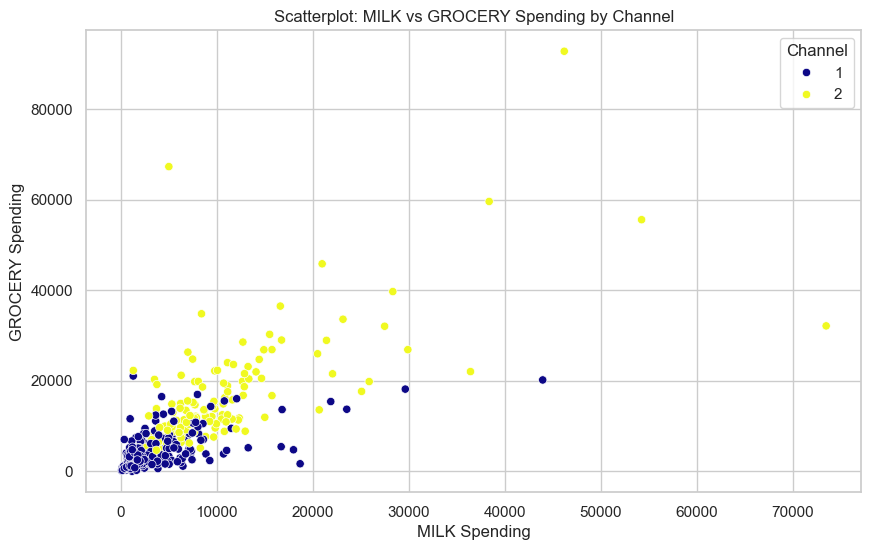

In [60]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Milk', y='Grocery', hue='Channel', palette='plasma')
plt.title('Scatterplot: MILK vs GROCERY Spending by Channel')
plt.xlabel('MILK Spending')
plt.ylabel('GROCERY Spending')
plt.legend(title='Channel')
plt.show()

**2.TASK: Use seaborn to create a histogram of MILK spending, colored by Channel. Can you figure out how to use seaborn to "stack" the channels, instead of have them overlap?**

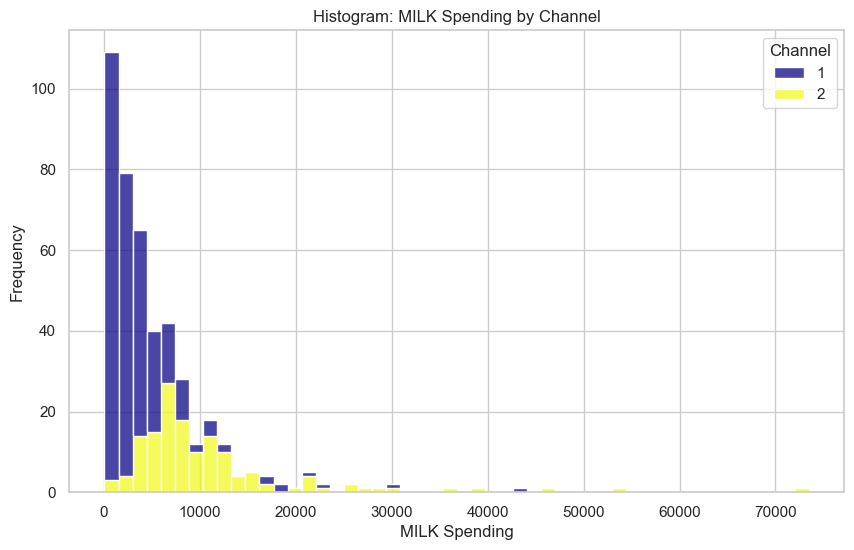

In [61]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Milk', hue='Channel', multiple='stack', palette='plasma')
plt.title('Histogram: MILK Spending by Channel')
plt.xlabel('MILK Spending')
plt.ylabel('Frequency')
plt.show()

**3.TASK: Create an annotated clustermap of the correlations between spending on different cateogires**

<Figure size 1200x800 with 0 Axes>

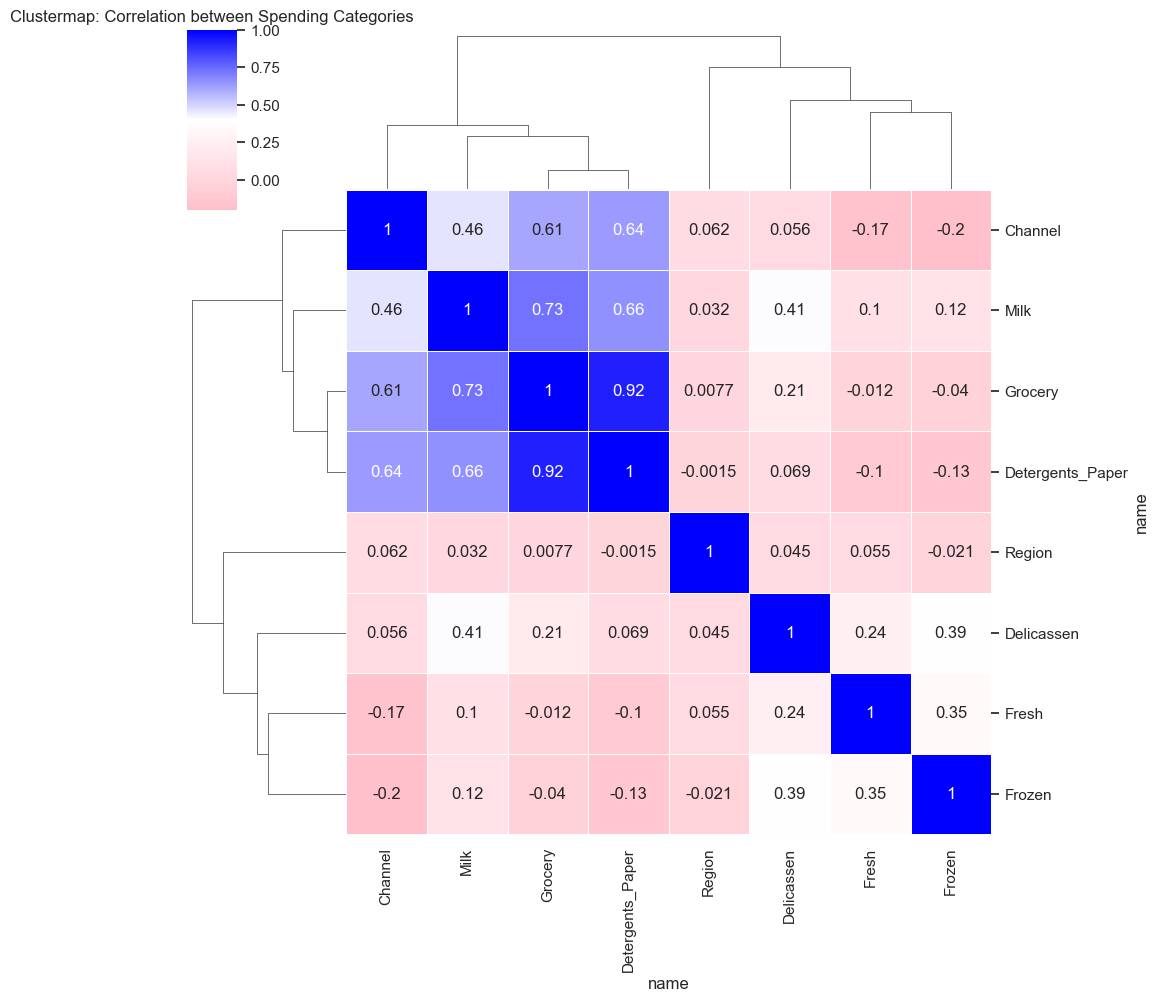

In [62]:
custom_cmap = LinearSegmentedColormap.from_list('custom_pink_blue', ['pink', 'white', 'blue'])

corr_matrix = df.corr()

corr_matrix.fillna(0, inplace=True)
corr_matrix = corr_matrix.replace([np.inf, -np.inf], 0)

plt.figure(figsize=(12, 8))
sns.clustermap(corr_matrix, annot=True, cmap=custom_cmap, linewidths=.5)
plt.title('Clustermap: Correlation between Spending Categories')
plt.show()

**4.TASK: Create a PairPlot of the dataframe, colored by Region.**

<Figure size 1200x800 with 0 Axes>

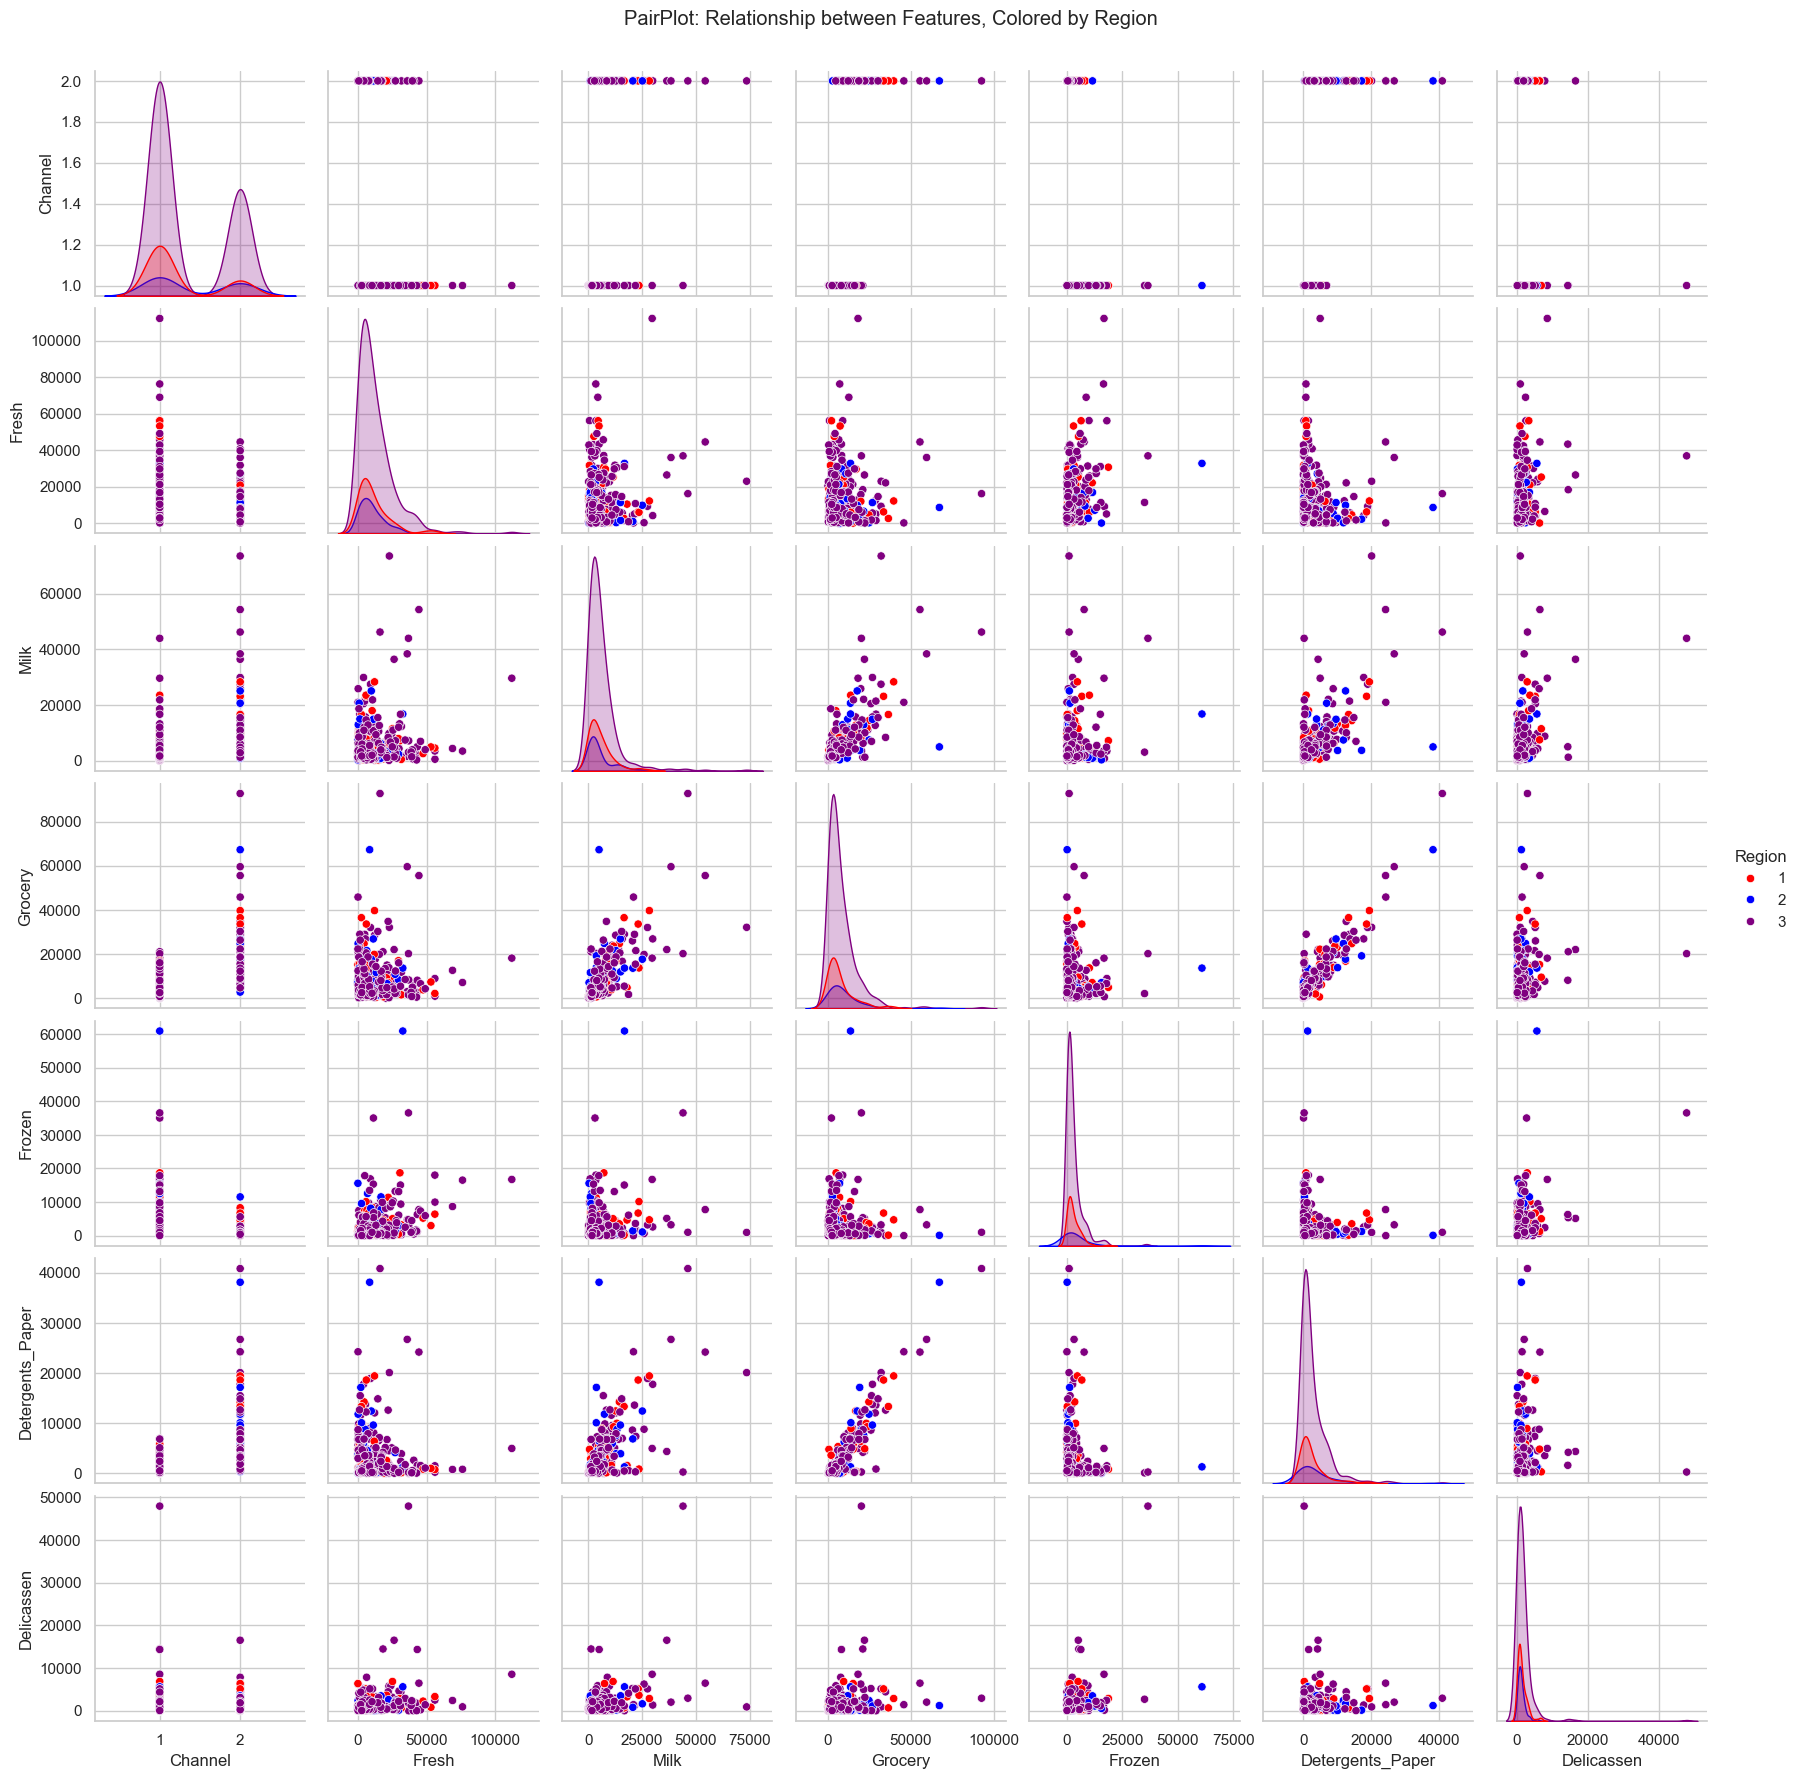

In [63]:
plt.figure(figsize=(12, 8))
sns.pairplot(data=df, hue='Region', palette=['red', 'blue', 'purple'])
plt.suptitle('PairPlot: Relationship between Features, Colored by Region', y=1.02)
plt.show()

**5.TASK: Since the values of the features are in different orders of magnitude, let's scale the data. Use StandardScaler to scale the data.**


In [64]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print(X_scaled_df.head())

    Channel     Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
0  1.448652  0.052933  0.523568 -0.041115 -0.589367         -0.043569   
1  1.448652 -0.391302  0.544458  0.170318 -0.270136          0.086407   
2  1.448652 -0.447029  0.408538 -0.028157 -0.137536          0.133232   
3 -0.690297  0.100111 -0.624020 -0.392977  0.687144         -0.498588   
4  1.448652  0.840239 -0.052396 -0.079356  0.173859         -0.231918   

   Delicassen  
0   -0.066339  
1    0.089151  
2    2.243293  
3    0.093411  
4    1.299347  


**6.TASK: Use DBSCAN and a for loop to create a variety of models testing different epsilon values. Set min_samples equal to 2 times the number of features. During the loop, keep track of and log the percentage of points that are outliers. For reference the solutions notebooks uses the following range of epsilon values for testing:**

In [65]:
epsilon_values = np.linspace(0.001, 3, 50)
percentage_outliers = []
min_samples = 2 * X.shape[1]

for epsilon in epsilon_values:
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    dbscan.fit(X_scaled)
    percentage_outlier = np.sum(dbscan.labels_ == -1) / len(dbscan.labels_) * 100
    percentage_outliers.append(percentage_outlier)
    print(percentage_outliers)

[100.0]
[100.0, 100.0]
[100.0, 100.0, 100.0]
[100.0, 100.0, 100.0, 100.0]
[100.0, 100.0, 100.0, 100.0, 100.0]
[100.0, 100.0, 100.0, 100.0, 100.0, 86.5909090909091]
[100.0, 100.0, 100.0, 100.0, 100.0, 86.5909090909091, 75.22727272727273]
[100.0, 100.0, 100.0, 100.0, 100.0, 86.5909090909091, 75.22727272727273, 67.04545454545455]
[100.0, 100.0, 100.0, 100.0, 100.0, 86.5909090909091, 75.22727272727273, 67.04545454545455, 62.95454545454545]
[100.0, 100.0, 100.0, 100.0, 100.0, 86.5909090909091, 75.22727272727273, 67.04545454545455, 62.95454545454545, 57.27272727272727]
[100.0, 100.0, 100.0, 100.0, 100.0, 86.5909090909091, 75.22727272727273, 67.04545454545455, 62.95454545454545, 57.27272727272727, 49.09090909090909]
[100.0, 100.0, 100.0, 100.0, 100.0, 86.5909090909091, 75.22727272727273, 67.04545454545455, 62.95454545454545, 57.27272727272727, 49.09090909090909, 40.22727272727273]
[100.0, 100.0, 100.0, 100.0, 100.0, 86.5909090909091, 75.22727272727273, 67.04545454545455, 62.95454545454545, 57

**7.TASK: Create a line plot of the percentage of outlier points versus the epsilon value choice.**

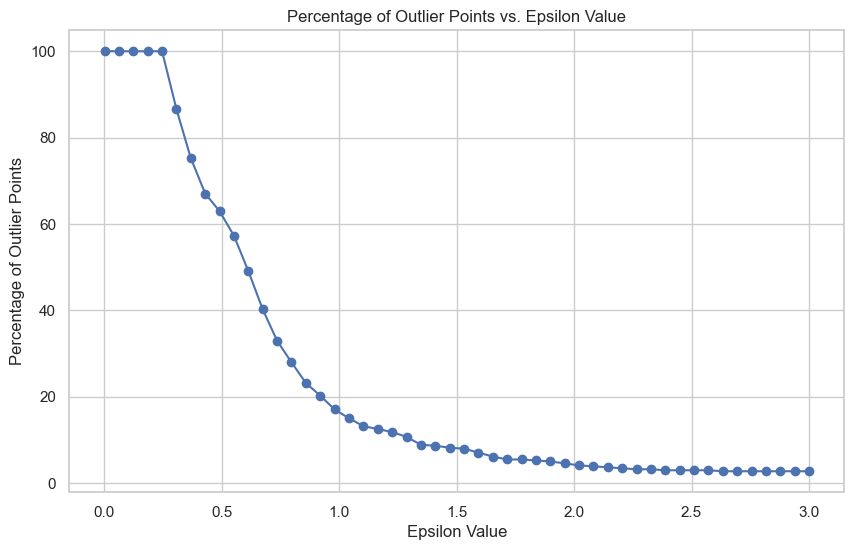

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, percentage_outliers, marker='o', linestyle='-')
plt.title('Percentage of Outlier Points vs. Epsilon Value')
plt.xlabel('Epsilon Value')
plt.ylabel('Percentage of Outlier Points')
plt.grid(True)
plt.show()

**8.DBSCAN with Chosen Epsilon TASK: Based on the plot created in the previous task, retrain a DBSCAN model with a reasonable epsilon value. Note: For reference, the solutions use eps=2.**

In [67]:
dbscan_model = DBSCAN(eps=2, min_samples=2*X.shape[1])  
dbscan_labels = dbscan_model.fit_predict(X_scaled) 
dbscan_results = pd.DataFrame({'DBSCAN_Labels': dbscan_labels})

print(dbscan_results.head())
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f'Number of clusters: {n_clusters}')
print(f'Number of noise points: {n_noise}')

   DBSCAN_Labels
0              0
1              0
2              0
3              1
4              0
Number of clusters: 2
Number of noise points: 18


**9.TASK: Create a scatterplot of Milk vs Grocery, colored by the discovered labels of the DBSCAN model.**

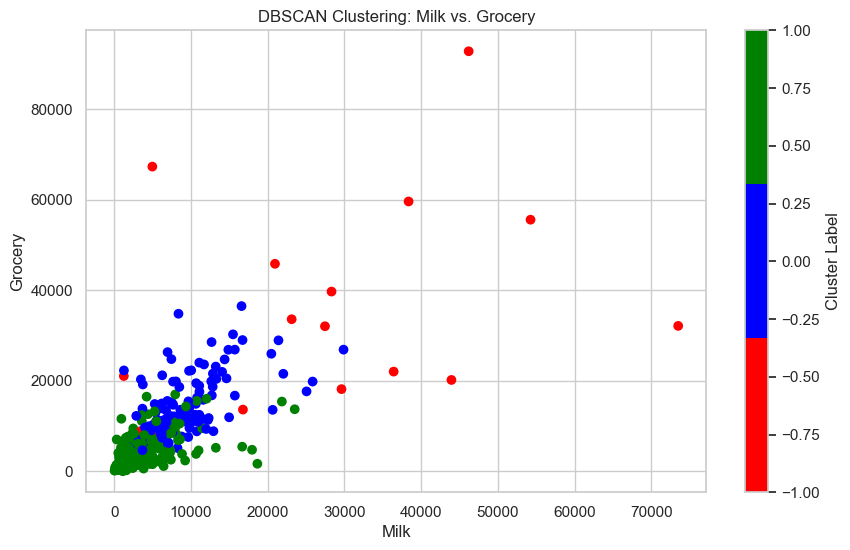

In [68]:
custom_cmap = ListedColormap(['red', 'blue', 'green'])

# Assuming dbscan_labels is the result of the DBSCAN fitting
dbscan_labels = dbscan_model.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(df['Milk'], df['Grocery'], c=dbscan_labels, cmap=custom_cmap)
plt.title('DBSCAN Clustering: Milk vs. Grocery')
plt.xlabel('Milk')
plt.ylabel('Grocery')
plt.colorbar(label='Cluster Label')
plt.show()

**10.TASK: Create a new column on the original dataframe called "Labels" consisting of the DBSCAN labels.**

In [69]:
df['Labels'] = dbscan_labels
df.head()

name,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Labels
0,2,3,12669,9656,7561,214,2674,1338,0
1,2,3,7057,9810,9568,1762,3293,1776,0
2,2,3,6353,8808,7684,2405,3516,7844,0
3,1,3,13265,1196,4221,6404,507,1788,1
4,2,3,22615,5410,7198,3915,1777,5185,0


**11.TASK: Compare the statistical mean of the clusters and outliers for the spending amounts on the categories.**

In [70]:
df['Labels'] = dbscan_labels
cluster_means = df.groupby('Labels').mean()
outlier_means = df[df['Labels'] == -1].mean()

print("Cluster Means:")
print(cluster_means)
print("\nOutlier Means:")
print(outlier_means)

Cluster Means:
name     Channel    Region         Fresh          Milk       Grocery  \
Labels                                                                 
-1      1.555556  2.666667  31601.555556  25574.166667  32205.277778   
 0      2.000000  2.621212   8200.681818   8849.446970  13919.113636   
 1      1.000000  2.500000  12513.148276   3178.948276   3729.462069   

name          Frozen  Detergents_Paper   Delicassen  
Labels                                               
-1      12694.000000      13882.722222  7869.444444  
 0       1527.174242       6037.280303  1548.310606  
 1       3177.831034        762.231034  1120.400000  

Outlier Means:
name
Channel                 1.555556
Region                  2.666667
Fresh               31601.555556
Milk                25574.166667
Grocery             32205.277778
Frozen              12694.000000
Detergents_Paper    13882.722222
Delicassen           7869.444444
Labels                 -1.000000
dtype: float64


**12.TASK: Normalize the dataframe from the previous task using MinMaxScaler so the spending means go from 0-1 and create a heatmap of the values.**

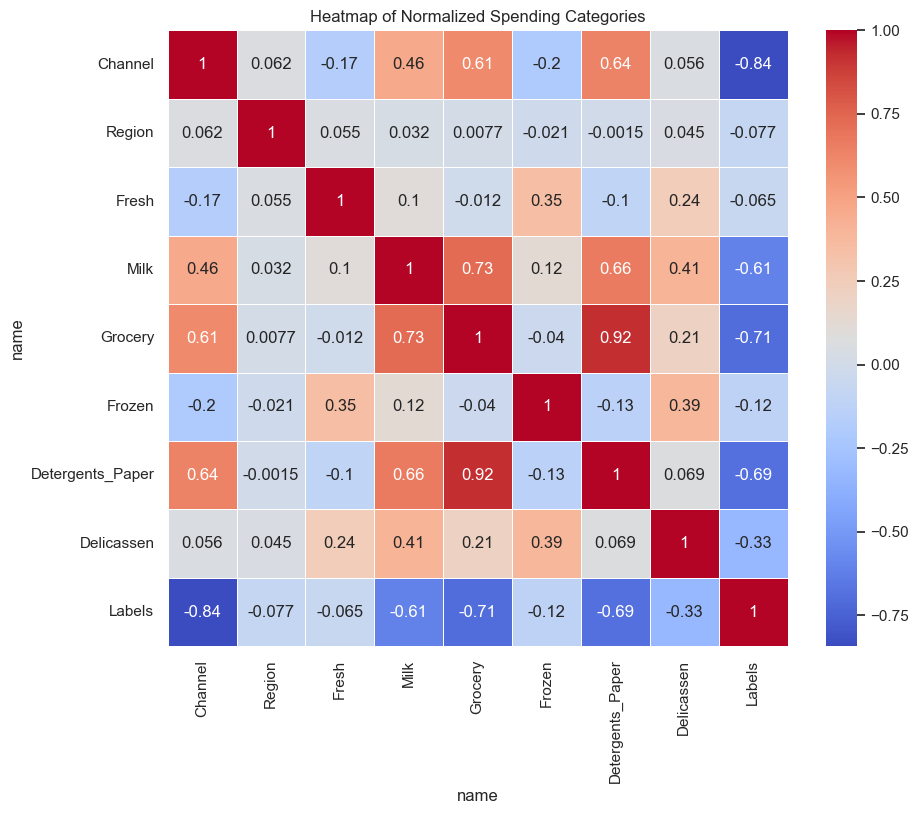

In [71]:
scaler = MinMaxScaler()

normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

plt.figure(figsize=(10, 8))
sns.heatmap(normalized_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Normalized Spending Categories')
plt.show()

**13.TASK: Create another heatmap similar to the one above, but with the outliers removed**

Number of rows before filtering: 440
Number of rows after filtering: 440


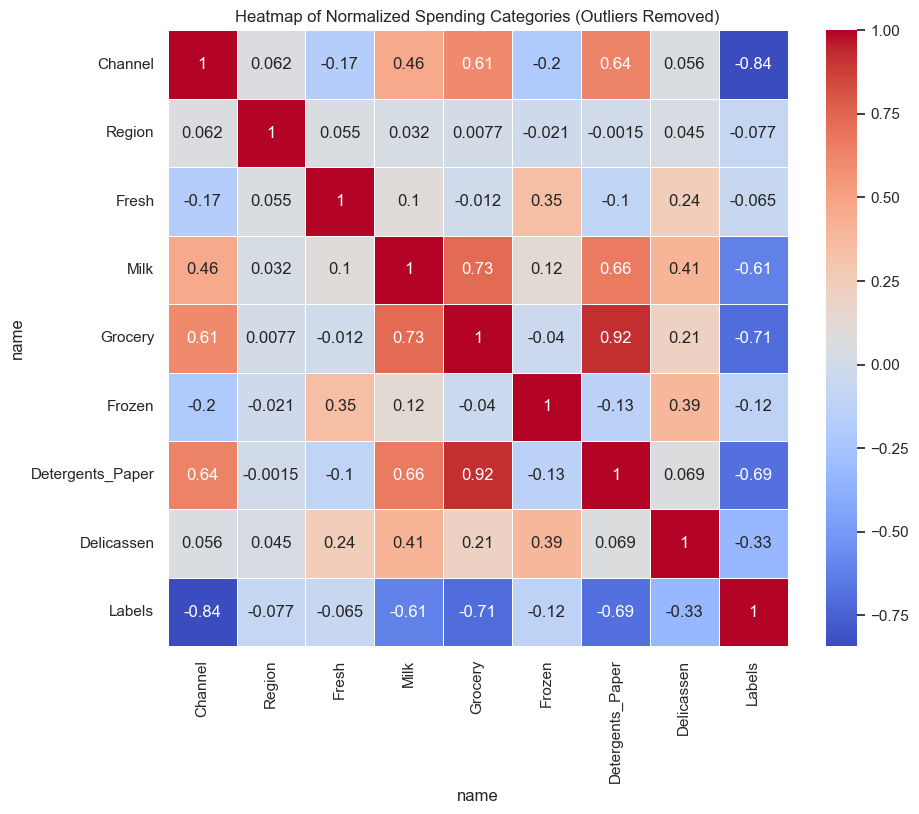

In [72]:
filtered_df = normalized_df[normalized_df['Labels'] != -1]

print("Number of rows before filtering:", len(normalized_df))
print("Number of rows after filtering:", len(filtered_df))

plt.figure(figsize=(10, 8))
sns.heatmap(filtered_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Normalized Spending Categories (Outliers Removed)')
plt.show()

**14.TASK: What spending category were the two clusters mode different in?**

In [73]:
cluster_means = df.groupby('Labels').mean()
absolute_difference = cluster_means.diff().abs()
absolute_difference = absolute_difference.dropna()

if not absolute_difference.empty:
    most_different_category = absolute_difference.idxmax()
else:
    most_different_category = None
    
print("Most different spending category between clusters:", most_different_category)

Most different spending category between clusters: name
Channel             1
Region              1
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64
